In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)


import time
from capytaine_generator import CapytaineSlantSolver
import capytaine as cpt

<class 'module'>
['c:\\Users\\15183\\miniconda3\\envs\\openflash-env\\Lib\\site-packages\\openflash']
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\openflash\__init__.py
OpenFLASH modules imported successfully!


In [2]:
css = CapytaineSlantSolver(False, True, False, False, False)
def compute_cpt_slant(config):
  t_densities = [30, 60]
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 50, config["h"], config["omega"], config["rho"], 1)
  am, dp, f_ex = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"], (cpt.assemble_dataset([respack[2]]))["excitation_force"][0][0][0].values
  return am, dp, f_ex

In [3]:
#generalize for M>2 regions?


i = 1
h = 15
a = [2, 4]
d = [6, 2] #d_in and d_out_init same for non-slants
d_in = d
d_out_init = d
omega = 0.9
rho = 1023


config = {"name" : "config-(" + str(i) + ")",
            "h" : h,
            "a" : a,
            "d_in" : d_in,
            "d_out" : d_out_init + [i],
            "heaving": [0, 1],
            "NMK" : [50, 50],
            "omega" : omega,
            "rho" : rho}

Capy_results = compute_cpt_slant(config)

Panel Count:  2100


In [4]:
Capy_results

(74269.8587715859, 22980.872886194556, array(254555.94493065-27563.94941792j))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)

<class 'module'>
['c:\\Users\\15183\\miniconda3\\envs\\openflash-env\\Lib\\site-packages\\openflash']
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\openflash\__init__.py
OpenFLASH modules imported successfully!


In [6]:
# ---------------------------------
# --- 1. Problem Setup ---
# ---------------------------------
print("\n--- 1. Setting up the Problem ---")
h = 1.001            # Water Depth (m)
d_list = [0.5, 0.25]   # Step depths (m) for inner and outer bodies
a_list = [0.5, 1.0]    # Radii (m) for inner and outer bodies
heaving_list = [True, False] # Heaving flags for each body
NMK = [30, 30, 30]     # Harmonics for inner, middle, and exterior domains

m0 = 1.0    # Non-dimensional wave number
problem_omega = omega(m0, h, g)
print(f"Wave number (m0): {m0}, Angular frequency (omega): {problem_omega:.4f}")


--- 1. Setting up the Problem ---
Wave number (m0): 1.0, Angular frequency (omega): 2.7341


In [7]:
# 1. Create a list of SteppedBody objects
bodies = []
for i in range(len(a_list)):
    body = SteppedBody(
        a=np.array([a_list[i]]),
        d=np.array([d_list[i]]),
        slant_angle=np.array([0.0]), # Assuming flat tops
        heaving=heaving_list[i]
    )
    bodies.append(body)

# 2. Group the bodies into an arrangement
arrangement = ConcentricBodyGroup(bodies)

# 3. Create a concrete Geometry instance
geometry = BasicRegionGeometry(
    body_arrangement=arrangement,
    h=h,
    NMK=NMK
)

# 4. Create the MEEMProblem instance
problem = MEEMProblem(geometry)

# 5. Set the frequencies for the problem
problem_frequencies = np.array([problem_omega])
problem.set_frequencies(problem_frequencies)
problem_modes = problem.modes # Get modes from geometry

print("Geometry and MEEM Problem initialized.")
print(f"Problem configured with {len(problem.frequencies)} frequency(ies) and {len(problem.modes)} mode(s): {problem_modes}.")

Geometry and MEEM Problem initialized.
Problem configured with 1 frequency(ies) and 1 mode(s): [0].


In [8]:
# 6. Initialize the MEEM Engine
engine = MEEMEngine(problem_list=[problem])
print("MEEMEngine initialized.")

# ---------------------------------
# --- WORKFLOW 1: Single Solve & Plot ---
# ---------------------------------
print("\n--- WORKFLOW 1: Solving for a single frequency ---")

# Solve the linear system.
# This one high-level call handles everything:
# 1. Calls _ensure_m_k_and_N_k_arrays
# 2. Calls assemble_A_multi
# 3. Calls assemble_b_multi
# 4. Solves the system for X
X = engine.solve_linear_system_multi(problem, m0)

print(f"Linear system solved. Solution vector X shape: {X.shape}")

MEEMEngine initialized.

--- WORKFLOW 1: Solving for a single frequency ---
Linear system solved. Solution vector X shape: (120,)


c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.46955e-30): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [9]:
# --- Get Coefficients from X ---
hydro_coefficients = engine.compute_hydrodynamic_coefficients(problem, X, m0)

if hydro_coefficients:
    df_coeffs = pd.DataFrame(hydro_coefficients)
    print("\nCalculated Hydrodynamic Coefficients:")
    print(df_coeffs)
else:
    print("Hydrodynamic coefficients could not be calculated.")


Calculated Hydrodynamic Coefficients:
   mode        real        imag  nondim_real  nondim_imag  excitation_phase  \
0     0  288.978396  189.013785     0.719333     0.172085         -0.521015   
1     1  595.741621  592.674309     0.185367     0.067449         -0.521015   

   excitation_force  
0         63.330565  
1         84.274080  


In [10]:
hydro_coefficients

[{'mode': np.int64(0),
  'real': np.float64(288.97839631487517),
  'imag': np.float64(189.0137852649591),
  'nondim_real': np.float64(0.7193327893690108),
  'nondim_imag': np.float64(0.1720846113086449),
  'excitation_phase': np.float64(-0.5210148529260973),
  'excitation_force': np.float64(63.33056538014957)},
 {'mode': np.int64(1),
  'real': np.float64(595.7416207006088),
  'imag': np.float64(592.674308717019),
  'nondim_real': np.float64(0.18536700633446512),
  'nondim_imag': np.float64(0.06744886881214676),
  'excitation_phase': np.float64(-0.5210148529260973),
  'excitation_force': np.float64(84.27408012093726)}]


--- WORKFLOW 3: Frequency Sweep & Coefficient Plotting ---
Setting up 2-body problem for sweep...
Sweep problem configured with 40 frequencies and 1 modes: [0].
Running frequency sweep... (This may take a moment)


c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.87023e-30): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.11754e-30): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.35782e-30): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.59491e-30): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matr

Hydrodynamic coefficients stored in xarray dataset.
Potentials stored in xarray dataset (batched across frequencies/modes).
Sweep complete.
Extracting data and plotting coefficients...


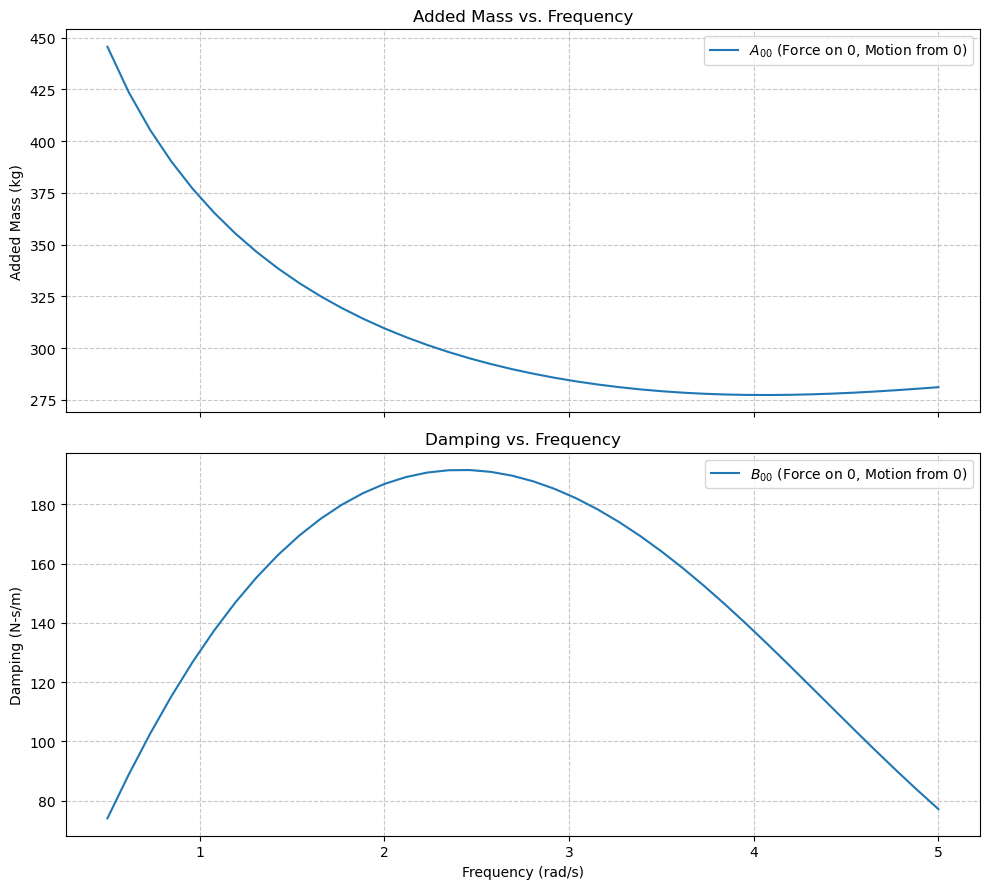


Tutorial finished.


In [11]:
# ---------------------------------
# --- WORKFLOW 3: Frequency Sweep & Coefficient Plotting ---
# ---------------------------------
# This workflow shows a common use case:
# 1. Define a problem where *all* bodies can move (heaving=[True, True])
# 2. Run a sweep over a range of frequencies.
# 3. Plot the resulting 2x2 Added Mass and Damping matrices.

print("\n--- WORKFLOW 3: Frequency Sweep & Coefficient Plotting ---")

# --- 3.1. Define the Problem for a Full 2-Body Sweep ---
# We define the problem so that *both* bodies are
# included as active modes (degrees of freedom).
print("Setting up 2-body problem for sweep...")

# Use the same geometric parameters from Section 1
h = 1.001
d_list = [0.5, 0.25]
a_list = [0.5, 1.0]
NMK = [30, 30, 30]

# --- KEY CHANGE ---
# Set heaving to [True, True] so that problem.modes becomes [0, 1].
# This tells run_and_store_results to solve the full 2x2 N-body problem.
heaving_list_sweep = [True, False]

# 1. Create SteppedBody objects
bodies_sweep = []
for i in range(len(a_list)):
    body = SteppedBody(
        a=np.array([a_list[i]]),
        d=np.array([d_list[i]]),
        slant_angle=np.array([0.0]),
        heaving=heaving_list_sweep[i]
    )
    bodies_sweep.append(body)

# 2. Create arrangement
arrangement_sweep = ConcentricBodyGroup(bodies_sweep)

# 3. Create geometry
geometry_sweep = BasicRegionGeometry(
    body_arrangement=arrangement_sweep,
    h=h,
    NMK=NMK
)

# 4. Create the MEEMProblem instance
problem_sweep = MEEMProblem(geometry_sweep)

# 5. Set the frequencies for the sweep
# We will run for 40 frequencies from 0.5 to 5.0 rad/s
omega_sweep = np.linspace(0.5, 5.0, 40)
problem_sweep.set_frequencies(omega_sweep)

print(f"Sweep problem configured with {len(problem_sweep.frequencies)} frequencies and {len(problem_sweep.modes)} modes: {problem_sweep.modes}.")

# 6. Initialize a new MEEM Engine for this problem
engine_sweep = MEEMEngine(problem_list=[problem_sweep])

# --- 3.2. Run the Full Sweep ---
print("Running frequency sweep... (This may take a moment)")
# This one call solves the radiation problem for each mode (0 and 1)
# at each of the 40 frequencies.
results_obj_sweep = engine_sweep.run_and_store_results(problem_index=0)
print("Sweep complete.")

# --- 3.3. Extract and Plot Hydrodynamic Coefficients ---
print("Extracting data and plotting coefficients...")

# Get the xarray.Dataset
ds_sweep = results_obj_sweep.get_results()

# Extract the Added Mass and Damping matrices.
# These are 3D arrays: (frequency, mode_j, mode_i)
# A[freq, 1, 0] = Added Mass on body 1 due to motion of body 0
A_sweep = ds_sweep.added_mass
B_sweep = ds_sweep.damping
freqs_out = ds_sweep.frequency # This is the same as omega_sweep

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

# --- Plot 1: Added Mass ---
ax1.plot(freqs_out, A_sweep[:, 0, 0], label=r'$A_{00}$ (Force on 0, Motion from 0)')
# ax1.plot(freqs_out, A_sweep[:, 0, 1], label=r'$A_{01}$ (Force on 0, Motion from 1)', linestyle='--')
# ax1.plot(freqs_out, A_sweep[:, 1, 0], label=r'$A_{10}$ (Force on 1, Motion from 0)', linestyle=':')
# ax1.plot(freqs_out, A_sweep[:, 1, 1], label=r'$A_{11}$ (Force on 1, Motion from 1)', linestyle='-.')
ax1.set_ylabel('Added Mass (kg)')
ax1.set_title('Added Mass vs. Frequency')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# --- Plot 2: Damping ---
ax2.plot(freqs_out, B_sweep[:, 0, 0], label=r'$B_{00}$ (Force on 0, Motion from 0)')
# ax2.plot(freqs_out, B_sweep[:, 0, 1], label=r'$B_{01}$ (Force on 0, Motion from 1)', linestyle='--')
# ax2.plot(freqs_out, B_sweep[:, 1, 0], label=r'$B_{10}$ (Force on 1, Motion from 0)', linestyle=':')
# ax2.plot(freqs_out, B_sweep[:, 1, 1], label=r'$B_{11}$ (Force on 1, Motion from 1)', linestyle='-.')
ax2.set_ylabel('Damping (N-s/m)')
ax2.set_title('Damping vs. Frequency')
ax2.set_xlabel('Frequency (rad/s)')
ax2.legend()
ax2.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


print("\nTutorial finished.")

In [19]:
A_sweep

<xarray.DataArray 'added_mass' (frequency: 40, mode_i: 1, mode_j: 1)> Size: 320B
array([[[445.63394659]],

       [[423.63586851]],

       [[405.4990942 ]],

       [[390.16742101]],

       [[376.98274596]],

       [[365.50338669]],

       [[355.41605247]],

       [[346.48893517]],

       [[338.54480232]],

       [[331.44461966]],

...

       [[277.37903107]],

       [[277.33013269]],

       [[277.42318344]],

       [[277.64823369]],

       [[277.99458606]],

       [[278.45081741]],

       [[279.00487622]],

       [[279.64424863]],

       [[280.35617927]],

       [[281.12792693]]])
Coordinates:
  * frequency  (frequency) float64 320B 0.5 0.6154 0.7308 ... 4.769 4.885 5.0
  * mode_i     (mode_i) int64 8B 0
  * mode_j     (mode_j) int64 8B 0

In [20]:
ds_sweep

<xarray.Dataset> Size: 120kB
Dimensions:             (frequency: 40, mode_i: 1, mode_j: 1, harmonics: 60,
                         domain_name: 3, modes: 1)
Coordinates:
  * frequency           (frequency) float64 320B 0.5 0.6154 0.7308 ... 4.885 5.0
  * mode_i              (mode_i) int64 8B 0
  * mode_j              (mode_j) int64 8B 0
  * harmonics           (harmonics) int64 480B 0 1 2 3 4 5 ... 54 55 56 57 58 59
  * domain_name         (domain_name) int64 24B 0 1 2
  * modes               (modes) int64 8B 0
Data variables:
    added_mass          (frequency, mode_i, mode_j) float64 320B 445.6 ... 281.1
    damping             (frequency, mode_i, mode_j) float64 320B 74.03 ... 77.12
    potentials_real     (frequency, modes, domain_name, harmonics) float64 58kB ...
    potentials_imag     (frequency, modes, domain_name, harmonics) float64 58kB ...
    potential_r_coords  (domain_name, harmonics) float64 1kB 0.0 0.0 ... nan nan
    potential_z_coords  (domain_name, harmonics) float64 1kB 0.0 0.0 ... nan nan

In [21]:
# MEEM

h = 1.00 # sea depth [m]
d_list = [0.5, 0.25] # drafts [m] 
a_list = [0.5, 1.0] # radii [m]
NMK = [100, 100, 100] # number of coefficients in each region 

heaving_list_sweep = [False, True]



# 1. Create SteppedBody objects
bodies_sweep = []
for i in range(len(a_list)):
    body = SteppedBody(
        a=np.array([a_list[i]]),
        d=np.array([d_list[i]]),
        slant_angle=np.array([0.0]),
        heaving=heaving_list_sweep[i]
    )
    bodies_sweep.append(body)

# 2. Create arrangement
arrangement_sweep = ConcentricBodyGroup(bodies_sweep)

# 3. Create geometry
geometry_sweep = BasicRegionGeometry(
    body_arrangement=arrangement_sweep,
    h=h,
    NMK=NMK
)

# 4. Create the MEEMProblem instance
problem_sweep = MEEMProblem(geometry_sweep)

# 5. Set the frequencies for the sweep
# We will run for 40 frequencies from 0.5 to 5.0 rad/s
omega_sweep = np.linspace(0.4, 1.5, 20)
problem_sweep.set_frequencies(omega_sweep)

# 6. Initialize a new MEEM Engine for this problem
engine_sweep = MEEMEngine(problem_list=[problem_sweep])

# --- 3.2. Run the Full Sweep ---
results_obj_sweep = engine_sweep.run_and_store_results(problem_index=0)

# Get the xarray.Dataset
ds_sweep = results_obj_sweep.get_results()

# Extract the Added Mass and Damping matrices.
# These are 3D arrays: (frequency, mode_j, mode_i)
# A[freq, 1, 0] = Added Mass on body 1 due to motion of body 0
A_MEEM = ds_sweep.added_mass
B_MEEM = ds_sweep.damping

c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.55265e-94): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.62998e-94): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.70488e-94): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.77798e-94): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matr

Hydrodynamic coefficients stored in xarray dataset.
Potentials stored in xarray dataset (batched across frequencies/modes).


c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.91808e-94): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [22]:
i = 1
h = 15
d_in = d_list
d_out_init = d_list
rho = 1023


A_BEM = np.zeros_like(omega_sweep)
B_BEM = np.zeros_like(omega_sweep)
F_ex_BEM = np.zeros(len(omega_sweep), dtype=np.complex128)

for j in range(len(omega_sweep)):
    
    print(j)

    omega = omega_sweep[j]
    config = {"name" : "config-(" + str(i) + ")",
                "h" : h,
                "a" : a_list,
                "d_in" : d_in,
                "d_out" : d_out_init + [i],
                "heaving": [0, 1],
                "NMK" : [100, 100],
                "omega" : omega,
                "rho" : rho}
    Capy_results = compute_cpt_slant(config)
    A_BEM[j] = Capy_results[0]
    B_BEM[j] = Capy_results[1]
    F_ex_BEM[j] = Capy_results[2]

0
Panel Count:  2250
1
Panel Count:  2250
2
Panel Count:  2250
3
Panel Count:  2250
4
Panel Count:  2250
5
Panel Count:  2250
6
Panel Count:  2250
7
Panel Count:  2250
8
Panel Count:  2250
9
Panel Count:  2250
10
Panel Count:  2250
11
Panel Count:  2250
12
Panel Count:  2250
13
Panel Count:  2250
14
Panel Count:  2250
15
Panel Count:  2250
16
Panel Count:  2250
17
Panel Count:  2250
18
Panel Count:  2250
19
Panel Count:  2250


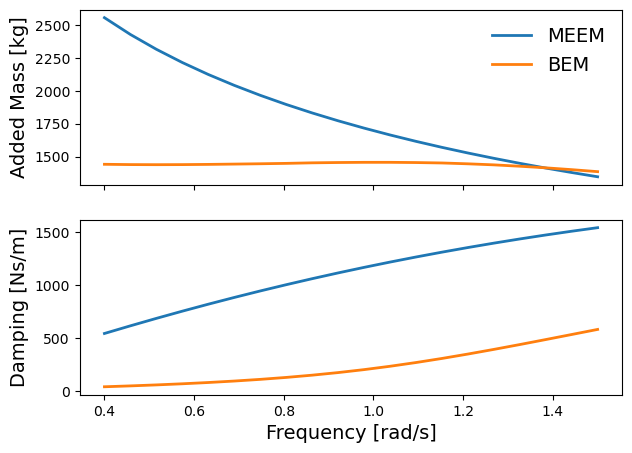

In [34]:
l_width = 2
fs = 14
fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
ax[0].plot(omega_sweep, A_MEEM.squeeze(), linestyle='-', label='MEEM', linewidth=l_width)
ax[0].plot(omega_sweep, A_BEM.squeeze(), linestyle='-', label='BEM', linewidth=l_width)
# ax[0].set_xlabel('Frequency [rad/s]', fontsize=fs)
ax[0].set_ylabel('Added Mass [kg]', fontsize=fs)
ax[0].legend(loc='best', fontsize=fs, frameon=False)


ax[1].plot(omega_sweep, B_MEEM.squeeze(), linestyle='-', label='MEEM', linewidth=l_width)
ax[1].plot(omega_sweep, B_BEM.squeeze(), linestyle='-', label='BEM', linewidth=l_width)
ax[1].set_xlabel('Frequency [rad/s]', fontsize=fs)
ax[1].set_ylabel('Damping [Ns/m]', fontsize=fs)
fig.savefig("Hydro_Coeffs.jpg", format='jpeg', dpi=300, bbox_inches='tight')
